<a href="https://colab.research.google.com/github/am88tech/agentic-trading/blob/main/agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Data ready for ADANIPOWER.NS — 1742 rows from 2018-10-23 to 2025-11-10
Iter 0: idx 0 score -2.781 Sharpe -1.813 DD -0.484
Iter 5: idx 0 score -2.781 Sharpe -1.813 DD -0.484
Iter 10: idx 1 score -3.979 Sharpe -2.488 DD -0.745
Iter 15: idx 0 score -2.781 Sharpe -1.813 DD -0.484
Iter 20: idx 2 score 1.375 Sharpe 1.655 DD -0.140
Iter 25: idx 2 score 1.375 Sharpe 1.655 DD -0.140

Best candidate: {'rules': ['macd_cross'], 'params': {}}
        score    sharpe      cagr    max_dd   pnl_pct
idx                                                  
2    1.375106  1.654881  0.144525 -0.139888  1.590040
0   -2.780525 -1.813007 -0.089522 -0.483759 -0.483759
3   -3.745778 -2.498726 -0.129397 -0.623526 -0.623526
1   -3.978578 -2.488268 -0.176273 -0.745155 -0.745155

=== Final Backtest Summary (assumptions shown) ===
Initial capital: ₹100,000.00
Final equity:    ₹259,283.92
Profit / Loss:   ₹159,283.92  (159.28%)
Sharpe:          1.655
CAGR:            0.145
Max Drawdown:    -0.140
Number of trades: 61

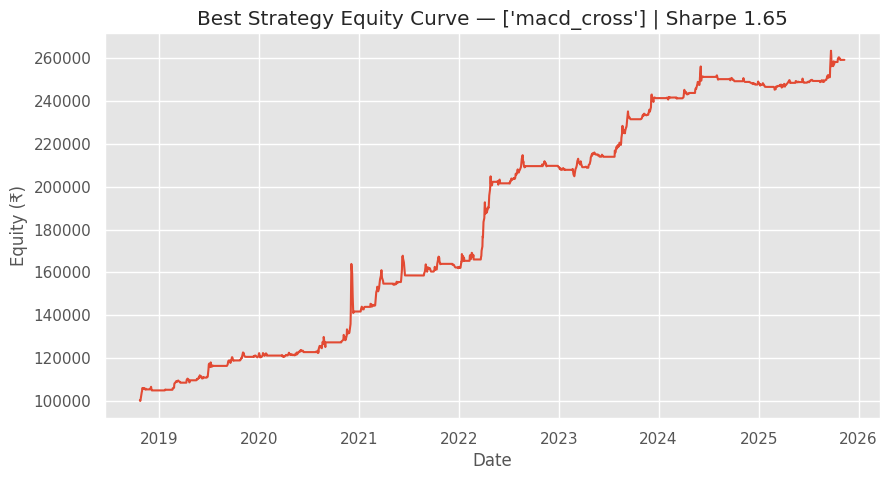


Top 5 indicator combinations (ranked by score = sharpe - 2*|max_dd|):

Rank 1: Combo = ['SMA50_above_SMA200', 'STOCH_K_above_D']
  Score: 4.9836  Sharpe: 4.997  CAGR: 0.218  MaxDD: -0.006
  PnL%: 302.19%  Trades: 244  Win-rate: 84.4%  Turnover: 56.62
  Total net trade PnL (₹): 302628.28  Avg trade (₹): 1240.28
--------------------------------------------------------------------------------
Rank 2: Combo = ['OBV_pos', 'STOCH_K_above_D']
  Score: 4.9475  Sharpe: 4.970  CAGR: 0.226  MaxDD: -0.011
  PnL%: 320.92%  Trades: 241  Win-rate: 83.4%  Turnover: 57.24
  Total net trade PnL (₹): 320920.89  Avg trade (₹): 1331.62
--------------------------------------------------------------------------------
Rank 3: Combo = ['Price_above_SMA200', 'STOCH_K_above_D']
  Score: 4.6906  Sharpe: 4.702  CAGR: 0.221  MaxDD: -0.006
  PnL%: 307.78%  Trades: 235  Win-rate: 85.1%  Turnover: 54.89
  Total net trade PnL (₹): 308222.06  Avg trade (₹): 1311.58
------------------------------------------------------

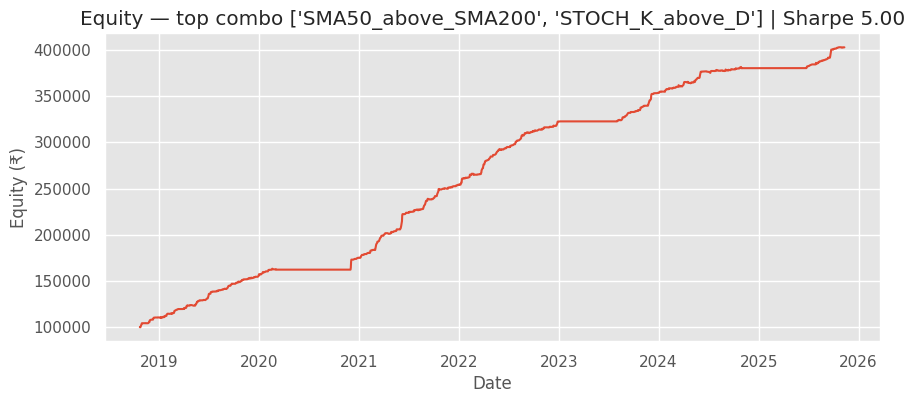


=== TODAY SUGGESTION ===
{
  "date": "2025-11-10",
  "ticker": "ADANIPOWER.NS",
  "indicator_combo": [
    "SMA50_above_SMA200",
    "STOCH_K_above_D"
  ],
  "signal": 0,
  "price_open": 152.75,
  "price_close": 150.05999755859375,
  "atr": 5.067854745047433,
  "note": "No buy signal today per selected strategy"
}
Wrote: today_suggestion_ADANIPOWER_NS_20251111.txt


In [30]:
# Optional: uncomment to install if running in a fresh environment
# !pip install --quiet yfinance matplotlib pandas

"""
Complete backtest notebook:
- Fetches data with yfinance
- Computes indicators (trend, momentum, volume, volatility)
- Generates candidate rules and combos
- Backtests with realistic assumptions: ATR-based sizing, flat brokerage + GST, slippage
- Reports monetary results for an initial capital (INR)
- Evaluates and ranks indicator combinations
"""

# ---------------------------- Imports & config ----------------------------
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
import itertools
from math import isnan, floor
import json

pd.set_option('display.max_columns', 200)
#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')


# -------------------------- User-configurable assumptions --------------------------
INIT_CAPITAL = 100000.0         # INR initial capital used to compute monetary PnL
RISK_PER_TRADE = 0.01           # fraction of portfolio risked per trade (1%)
BROKERAGE_PER_ORDER = 20.0      # flat brokerage per order in INR (example: Zerodha intraday)
GST_RATE = 0.18                 # GST on brokerage
SLIPPAGE_PCT = 0.0005           # 0.05% slippage per trade (entry/exit)
MIN_SHARES = 1                  # minimum tradable shares (no lot handling)
ANNUAL_FACTOR = 252             # trading days per year for annualization

# ---------------------------- Indicator functions ----------------------------
def SMA(series, n):
    return series.rolling(window=n, min_periods=n).mean()

def EMA(series, n):
    return series.ewm(span=n, adjust=False, min_periods=n).mean()

def RSI(series, n=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=n, min_periods=n).mean()
    ma_down = down.rolling(window=n, min_periods=n).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

def MACD(series, n_fast=12, n_slow=26, n_signal=9):
    ema_fast = EMA(series, n_fast)
    ema_slow = EMA(series, n_slow)
    macd = ema_fast - ema_slow
    signal = EMA(macd, n_signal)
    hist = macd - signal
    return macd, signal, hist

def ATR(high, low, close, n=14):
    high_low = high - low
    high_close = (high - close.shift(1)).abs()
    low_close = (low - close.shift(1)).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=n, min_periods=n).mean()

def bollinger_bands(series, n=20, n_std=2):
    ma = series.rolling(window=n, min_periods=n).mean()
    std = series.rolling(window=n, min_periods=n).std()
    return ma - n_std*std, ma, ma + n_std*std

def rolling_volatility(returns, n=20, annualize=252):
    return returns.rolling(window=n, min_periods=n).std() * np.sqrt(annualize)

def volume_zscore(volume, n=20):
    return (volume - volume.rolling(n).mean()) / (volume.rolling(n).std() + 1e-12)

# Additional indicators
def OBV(close, volume):
    sign = np.sign(close.diff().fillna(0))
    obv = (sign * volume).cumsum()
    return obv

def VOL_SMA(volume, n=20):
    return volume.rolling(window=n, min_periods=1).mean()

def VROC(volume, n=10):
    return volume.pct_change(periods=n)

def CMF(high, low, close, volume, n=20):
    tp = (close + high + low) / 3
    mf = (tp - tp.shift(1)) / (high - low + 1e-12) * volume
    return mf.rolling(window=n, min_periods=1).sum() / (volume.rolling(window=n, min_periods=1).sum() + 1e-12)

def MFI(high, low, close, volume, n=14):
    typical = (high + low + close) / 3
    tp_diff = typical.diff()
    pos = ((tp_diff > 0) * (typical * volume)).rolling(window=n).sum()
    neg = ((tp_diff < 0) * (typical * volume)).rolling(window=n).sum().abs()
    mfr = pos / (neg + 1e-12)
    return 100 - (100 / (1 + mfr))

def ROC(series, n=12):
    return series.pct_change(periods=n)

def STOCH(high, low, close, n=14, d_n=3):
    lowest = low.rolling(window=n, min_periods=1).min()
    highest = high.rolling(window=n, min_periods=1).max()
    k = 100 * (close - lowest) / (highest - lowest + 1e-12)
    d = k.rolling(window=d_n, min_periods=1).mean()
    return k, d

def BB_width(close, n=20, n_std=2):
    l, m, u = bollinger_bands(close, n, n_std)
    return (u - l) / (m + 1e-12)

def HV(returns, n=20, annualize=252):
    return returns.rolling(window=n, min_periods=1).std() * np.sqrt(annualize)

# ---------------------------- Data fetch & clean ----------------------------
TICKER = "ADANIPOWER.NS"
START = "2018-01-01"
END = datetime.today().strftime("%Y-%m-%d")

df = yf.download(TICKER, start=START, end=END, progress=False, auto_adjust=False)

if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

# Drop 'Adj Close' unless you need it
if 'Adj Close' in df.columns:
    df.drop(columns=['Adj Close'], inplace=True)

# Drop rows with any NaN values (optional)
df.dropna(inplace=True)

# ---------------------------- Compute indicators ----------------------------
# basic
df['SMA_20'] = SMA(df['Close'], 20)
df['SMA_50'] = SMA(df['Close'], 50)
df['EMA_20'] = EMA(df['Close'], 20)
df['EMA_50'] = EMA(df['Close'], 50)
df['RSI_14'] = RSI(df['Close'], 14)
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = MACD(df['Close'])
df['ATR_14'] = ATR(df['High'], df['Low'], df['Close'], 14)
df['BBL'], df['BBM'], df['BBU'] = bollinger_bands(df['Close'], 20, 2)
df['RET'] = df['Close'].pct_change()
df['VOL_20'] = rolling_volatility(df['RET'], n=20)
df['VOL_Z'] = volume_zscore(df['Volume'], n=20)

# additional
df['OBV'] = OBV(df['Close'], df['Volume'])
df['VOL_SMA_20'] = VOL_SMA(df['Volume'], 20)
df['VROC_10'] = VROC(df['Volume'], 10)
df['CMF_20'] = CMF(df['High'], df['Low'], df['Close'], df['Volume'], 20)
df['MFI_14'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 14)
df['ROC_12'] = ROC(df['Close'], 12)
df['STOCH_K'], df['STOCH_D'] = STOCH(df['High'], df['Low'], df['Close'], 14, 3)
df['BB_WIDTH'] = BB_width(df['Close'], 20, 2)
df['HV_20'] = HV(df['RET'].fillna(0), 20)
df['SMA_200'] = SMA(df['Close'], 200)

df = df.dropna().copy()
print(f"✅ Data ready for {TICKER} — {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")

# ---------------------------- Signal utilities & backtester ----------------------------
def _normalize_signal_obj(signals, df_index):
    if isinstance(signals, (list, np.ndarray)):
        s = pd.Series(signals, index=df_index)
    elif isinstance(signals, pd.Series):
        s = signals.copy()
    elif isinstance(signals, pd.DataFrame):
        if 'signal' in signals.columns:
            s = signals['signal'].copy()
        else:
            s = signals.iloc[:,0].copy()
    else:
        raise TypeError("signals must be Series, DataFrame, list, or ndarray")
    s.index = pd.to_datetime(s.index)
    if getattr(s.index,'tz',None) is not None:
        s.index = s.index.tz_convert(None)
    s = s.reindex(df_index).fillna(0)
    s = pd.Series(np.where(np.array(s).astype(float) >= 0.5, 1, 0), index=df_index, name='signal').astype(int)
    return s

def backtest_rules(df, signals, init_capital=INIT_CAPITAL,
                   risk_per_trade=RISK_PER_TRADE,
                   brokerage_per_order=BROKERAGE_PER_ORDER,
                   gst_rate=GST_RATE,
                   slippage_pct=SLIPPAGE_PCT):
    """
    Fixed-allocation sizing:
    - Per-trade risk is computed from the initial capital (init_capital * risk_per_trade).
      This prevents automatic reinvestment / compounding of position size.
    - Other mechanics (fees, slippage, execution at open) unchanged.
    """
    sig_series = _normalize_signal_obj(signals, df.index)
    sig_vals = np.asarray(sig_series.values, dtype=int)
    if sig_vals.shape[0] != len(df):
        raise ValueError("Signal length mismatch")

    cash = float(init_capital)
    position = 0
    shares = 0
    equity = []
    trades = []
    entry = None

    # fixed dollar risk per trade derived from initial capital (not current cash)
    fixed_dollar_risk = float(init_capital) * float(risk_per_trade)

    for i in range(len(df)):
        idx = df.index[i]
        price_open = float(df['Open'].iat[i])
        price_close = float(df['Close'].iat[i])
        atr_i = float(df['ATR_14'].iat[i]) if not np.isnan(df['ATR_14'].iat[i]) else 1.0
        if price_open <= 0:
            equity.append(cash + shares * price_close)
            continue

        s = int(sig_vals[i])

        # ENTRY (fixed-allocation sizing)
        if s == 1 and position == 0:
            per_share_risk = max(atr_i, 1e-6)
            # use fixed dollar risk (based on INIT_CAPITAL) instead of current cash
            target_shares = int(fixed_dollar_risk // per_share_risk)
            exec_price = price_open * (1 + slippage_pct)
            max_affordable = int(cash // exec_price)
            shares_to_buy = max(MIN_SHARES, min(target_shares, max_affordable)) if max_affordable >= MIN_SHARES else 0

            if shares_to_buy > 0:
                trade_value = shares_to_buy * exec_price
                brokerage = brokerage_per_order
                gst = brokerage * gst_rate
                total_fees = brokerage + gst
                cash -= (trade_value + total_fees)
                position = 1
                shares = shares_to_buy
                entry = dict(entry_date=idx, entry_price=exec_price, shares=shares_to_buy, fees=total_fees)

        # EXIT
        elif s == 0 and position == 1:
            exec_price = price_open * (1 - slippage_pct)
            trade_value = shares * exec_price
            brokerage = brokerage_per_order
            gst = brokerage * gst_rate
            total_fees = brokerage + gst
            cash += (trade_value - total_fees)
            if entry is not None:
                pnl_gross = (exec_price - entry['entry_price']) * shares
                pnl_net = pnl_gross - (entry['fees'] + total_fees)
                trades.append({
                    'entry_date': entry['entry_date'],
                    'exit_date': idx,
                    'entry_price': entry['entry_price'],
                    'exit_price': exec_price,
                    'shares': shares,
                    'pnl_gross': pnl_gross,
                    'pnl_net': pnl_net,
                    'fees_total': entry['fees'] + total_fees
                })
            position = 0
            shares = 0
            entry = None

        equity.append(cash + shares * price_close)

    eq_series = pd.Series(equity, index=df.index, name='equity')
    return eq_series, trades


# ---------------------------- Performance helpers ----------------------------
def performance_stats_from_equity(eq_series):
    returns = eq_series.pct_change().dropna()
    ann_factor = ANNUAL_FACTOR
    avg_ret = returns.mean() * ann_factor
    vol = returns.std() * np.sqrt(ann_factor)
    sharpe = avg_ret / vol if vol>0 else np.nan
    n_years = (eq_series.index[-1] - eq_series.index[0]).days / 365.25
    cagr = (eq_series.iloc[-1] / eq_series.iloc[0])**(1.0/n_years) - 1 if n_years>0 else np.nan
    roll_max = eq_series.cummax()
    drawdown = (eq_series - roll_max) / roll_max
    max_dd = drawdown.min()
    pnl_pct = eq_series.iloc[-1] / eq_series.iloc[0] - 1
    return dict(sharpe=sharpe, cagr=cagr, max_dd=max_dd, pnl_pct=pnl_pct)

def trade_aggregates(trades):
    if not trades:
        return {'num_trades':0,'win_rate':np.nan,'avg_pnl_net':0.0,'total_pnl_net':0.0,'avg_holding_days':0.0,'turnover':0.0}
    df_tr = pd.DataFrame(trades)
    num = len(df_tr)
    wins = (df_tr['pnl_net'] > 0).sum()
    win_rate = wins/num
    avg_pnl = df_tr['pnl_net'].mean()
    total_pnl = df_tr['pnl_net'].sum()
    holding_days = (pd.to_datetime(df_tr['exit_date']) - pd.to_datetime(df_tr['entry_date'])).dt.days
    avg_holding = holding_days.mean()
    turnover = (df_tr['entry_price'] * df_tr['shares']).sum() / INIT_CAPITAL
    return {'num_trades':int(num),'win_rate':float(win_rate),'avg_pnl_net':float(avg_pnl),'total_pnl_net':float(total_pnl),
            'avg_holding_days':float(avg_holding),'turnover':float(turnover)}

# ---------------------------- Basic rule set (for optimizer) ----------------------------
def rule_rsi_price(df, rsi_thresh=30):
    return (df['RSI_14'] < rsi_thresh).astype(int)

def rule_macd_cross(df):
    return (df['MACD'] > df['MACD_SIGNAL']).astype(int)

def rule_bb_reversion(df):
    return (df['Close'] < df['BBL']).astype(int)

def generate_signal(df, cand):
    arrs = []
    for r in cand.get('rules', []):
        if r == 'rsi_price':
            arrs.append(rule_rsi_price(df, cand.get('params', {}).get('rsi_thresh',30)).values)
        elif r == 'macd_cross':
            arrs.append(rule_macd_cross(df).values)
        elif r == 'bb_reversion':
            arrs.append(rule_bb_reversion(df).values)
        else:
            arrs.append(np.zeros(len(df), dtype=int))
    if arrs:
        combined = np.all(np.vstack(arrs) == 1, axis=0).astype(int)
    else:
        combined = np.zeros(len(df), dtype=int)
    return pd.DataFrame({'signal': combined}, index=df.index)

# ---------------------------- Small epsilon-greedy "agentic" optimizer ----------------------------
candidates = [
    {'rules':['rsi_price'], 'params':{'rsi_thresh':25}},
    {'rules':['rsi_price'], 'params':{'rsi_thresh':30}},
    {'rules':['macd_cross'], 'params':{}},
    {'rules':['bb_reversion'], 'params':{}},
    {'rules':['rsi_price','macd_cross'], 'params':{'rsi_thresh':30}},
    {'rules':['rsi_price','bb_reversion'], 'params':{'rsi_thresh':30}},
]

memory = {i:{'score':None,'trials':0} for i in range(len(candidates))}
results = []
random.seed(42)
for it in range(30):
    eps = 0.2
    if random.random() < eps:
        idx = random.choice(list(memory.keys()))
    else:
        scored = {k:v['score'] for k,v in memory.items() if v['score'] is not None}
        idx = max(scored, key=scored.get) if scored else random.choice(list(memory.keys()))
    cand = candidates[idx]
    sig = generate_signal(df, cand)
    eq, trades = backtest_rules(df, sig)
    stats = performance_stats_from_equity(eq)
    score = (stats['sharpe'] if not isnan(stats['sharpe']) else -10) - 2.0*abs(stats['max_dd'])
    mem = memory[idx]
    mem['trials'] += 1
    mem['score'] = score if mem['score'] is None else (mem['score']*(mem['trials']-1)+score)/mem['trials']
    results.append({'iter':it,'idx':idx,'score':score,**stats,'rules':cand['rules'],'params':cand['params']})
    if it%5==0:
        sharpe_disp = f"{stats['sharpe']:.3f}" if not isnan(stats['sharpe']) else "nan"
        print(f"Iter {it}: idx {idx} score {score:.3f} Sharpe {sharpe_disp} DD {stats['max_dd']:.3f}")

res_df = pd.DataFrame(results)
agg = res_df.groupby('idx').agg({'score':'max','sharpe':'mean','cagr':'mean','max_dd':'mean','pnl_pct':'mean'}).sort_values('score',ascending=False)
best_idx = agg.index[0]
best_cand = candidates[best_idx]
print("\nBest candidate:", best_cand)
print(agg.head())

# ---------------------------- Final evaluation of best candidate ----------------------------
# ---------------------------- Final evaluation of best candidate (fixed-allocation) ----------------------------
best_sig = generate_signal(df, best_cand)
best_eq, best_trades = backtest_rules(df, best_sig)
best_stats = performance_stats_from_equity(best_eq)
trade_stats = trade_aggregates(best_trades)

final_eq = best_eq.iloc[-1]
profit_loss_inr = final_eq - INIT_CAPITAL
pnl_pct = (final_eq / INIT_CAPITAL) - 1.0

# compute exact max profit / max loss trades if trades exist
if best_trades:
    trades_df = pd.DataFrame(best_trades)
    max_profit_row = trades_df.loc[trades_df['pnl_net'].idxmax()]
    max_loss_row = trades_df.loc[trades_df['pnl_net'].idxmin()]
    max_profit_value = float(trades_df['pnl_net'].max())
    max_loss_value = float(trades_df['pnl_net'].min())
else:
    trades_df = pd.DataFrame(columns=['entry_date','exit_date','entry_price','exit_price','shares','pnl_gross','pnl_net','fees_total'])
    max_profit_row = None
    max_loss_row = None
    max_profit_value = 0.0
    max_loss_value = 0.0

# Print to notebook
print("\n=== Final Backtest Summary (assumptions shown) ===")
print(f"Initial capital: ₹{INIT_CAPITAL:,.2f}")
print(f"Final equity:    ₹{final_eq:,.2f}")
print(f"Profit / Loss:   ₹{profit_loss_inr:,.2f}  ({pnl_pct*100:.2f}%)")
print(f"Sharpe:          {best_stats['sharpe']:.3f}")
print(f"CAGR:            {best_stats['cagr']:.3f}")
print(f"Max Drawdown:    {best_stats['max_dd']:.3f}")
print(f"Number of trades: {trade_stats['num_trades']}")
print(f"Win rate:        {trade_stats['win_rate']*100:.2f}%")
print(f"Avg trade PnL (net): ₹{trade_stats['avg_pnl_net']:.2f}")
print(f"Total trade PnL (net): ₹{trade_stats['total_pnl_net']:.2f}")
print(f"Avg holding (days): {trade_stats['avg_holding_days']:.1f}")
print(f"Turnover (entry volumes / init cap): {trade_stats['turnover']:.2f}")
print(f"Max single-trade profit (net): ₹{max_profit_value:,.2f}")
print(f"Max single-trade loss (net): ₹{max_loss_value:,.2f}")
if max_profit_row is not None:
    print("Max profit trade details:", max_profit_row.to_dict())
if max_loss_row is not None:
    print("Max loss trade details:", max_loss_row.to_dict())
print(f"Assumed brokerage per order: ₹{BROKERAGE_PER_ORDER:.2f}, GST: {GST_RATE*100:.1f}%, slippage: {SLIPPAGE_PCT*100:.3f}%")
print("=================================================\n")

# Save outputs to files (CSV + text summary)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
trades_file = f"trades_{TICKER.replace('.','_')}_{timestamp}.csv"
summary_file = f"backtest_summary_{TICKER.replace('.','_')}_{timestamp}.txt"

# write trades CSV
trades_df.to_csv(trades_file, index=False)

# prepare and write summary text
with open(summary_file, "w") as f:
    f.write("Final Backtest Summary\n")
    f.write("======================\n")
    f.write(f"Ticker: {TICKER}\n")
    f.write(f"Date range: {df.index[0].date()} to {df.index[-1].date()}\n")
    f.write(f"Initial capital: ₹{INIT_CAPITAL:,.2f}\n")
    f.write(f"Final equity: ₹{final_eq:,.2f}\n")
    f.write(f"Profit / Loss: ₹{profit_loss_inr:,.2f} ({pnl_pct*100:.2f}%)\n")
    f.write(f"Sharpe: {best_stats['sharpe']:.3f}\n")
    f.write(f"CAGR: {best_stats['cagr']:.3f}\n")
    f.write(f"Max Drawdown: {best_stats['max_dd']:.3f}\n")
    f.write(f"Number of trades: {trade_stats['num_trades']}\n")
    f.write(f"Win rate: {trade_stats['win_rate']*100:.2f}%\n")
    f.write(f"Avg trade PnL (net): ₹{trade_stats['avg_pnl_net']:.2f}\n")
    f.write(f"Total trade PnL (net): ₹{trade_stats['total_pnl_net']:.2f}\n")
    f.write(f"Avg holding (days): {trade_stats['avg_holding_days']:.1f}\n")
    f.write(f"Turnover: {trade_stats['turnover']:.2f}\n")
    f.write(f"Max single-trade profit (net): ₹{max_profit_value:,.2f}\n")
    f.write(f"Max single-trade loss (net): ₹{max_loss_value:,.2f}\n")
    if max_profit_row is not None:
        f.write("\nMax profit trade details:\n")
        f.write(str(max_profit_row.to_dict()) + "\n")
    if max_loss_row is not None:
        f.write("\nMax loss trade details:\n")
        f.write(str(max_loss_row.to_dict()) + "\n")
    f.write("\nAssumptions:\n")
    f.write(f"Brokerage per order: ₹{BROKERAGE_PER_ORDER:.2f}, GST: {GST_RATE*100:.1f}%, Slippage: {SLIPPAGE_PCT*100:.3f}%\n")

print(f"Wrote trades -> {trades_file}")
print(f"Wrote summary -> {summary_file}")

# plot equity for best candidate (unchanged)
plt.figure(figsize=(10,5))
plt.plot(best_eq.index, best_eq.values)
plt.title(f"Best Strategy Equity Curve — {best_cand['rules']} | Sharpe {best_stats['sharpe']:.2f}")
plt.xlabel("Date"); plt.ylabel("Equity (₹)")
plt.show()


# ---------------------------- Indicator-combination enumerator & evaluator ----------------------------
# Define candidate lists (5 each) across 4 categories (volume, trend, momentum, volatility)
volume_indicators = [
    'OBV_pos', 'VOL_above_SMA', 'VROC_pos', 'CMF_pos', 'MFI_low'
]

trend_indicators = [
    'SMA50_above_SMA200', 'EMA20_above_EMA50', 'MACD_pos', 'SMA20_above_SMA50', 'Price_above_SMA200'
]

momentum_indicators = [
    'RSI_oversold', 'ROC_pos', 'STOCH_K_above_D', 'MACD_hist_pos', 'MFI_rising'
]

volatility_indicators = [
    'ATR_below_ma', 'BB_width_low', 'HV_low', 'ATR_low_abs', 'BB_momentum'
]

# Rule implementations returning 0/1 Series
def rule_OBV_pos(df): return (df['OBV'] > df['OBV'].rolling(20).mean()).astype(int)
def rule_VOL_above_SMA(df): return (df['Volume'] > df['VOL_SMA_20']).astype(int)
def rule_VROC_pos(df): return (df['VROC_10'] > 0).astype(int)
def rule_CMF_pos(df): return (df['CMF_20'] > 0).astype(int)
def rule_MFI_low(df): return (df['MFI_14'] < 30).astype(int)
def rule_SMA50_above_SMA200(df): return (df['SMA_50'] > df['SMA_200']).astype(int)
def rule_EMA20_above_EMA50(df): return (df['EMA_20'] > df['EMA_50']).astype(int)
def rule_MACD_pos(df): return (df['MACD'] > df['MACD_SIGNAL']).astype(int)
def rule_SMA20_above_SMA50(df): return (df['SMA_20'] > df['SMA_50']).astype(int)
def rule_Price_above_SMA200(df): return (df['Close'] > df['SMA_200']).astype(int)
def rule_RSI_oversold(df): return (df['RSI_14'] < 30).astype(int)
def rule_ROC_pos(df): return (df['ROC_12'] > 0).astype(int)
def rule_STOCH_K_above_D(df): return (df['STOCH_K'] > df['STOCH_D']).astype(int)
def rule_MACD_hist_pos(df): return (df['MACD_HIST'] > 0).astype(int)
def rule_MFI_rising(df): return (df['MFI_14'].diff() > 0).astype(int)
def rule_ATR_below_ma(df): return (df['ATR_14'] < df['ATR_14'].rolling(20).mean()).astype(int)
def rule_BB_width_low(df): return (df['BB_WIDTH'] < df['BB_WIDTH'].median()).astype(int)
def rule_HV_low(df): return (df['HV_20'] < df['HV_20'].median()).astype(int)
def rule_ATR_low_abs(df): return (df['ATR_14'] < df['ATR_14'].quantile(0.5)).astype(int)
def rule_BB_momentum(df): return (df['BB_WIDTH'].diff() < 0).astype(int)

rule_map = {
    'OBV_pos': rule_OBV_pos, 'VOL_above_SMA': rule_VOL_above_SMA, 'VROC_pos': rule_VROC_pos,
    'CMF_pos': rule_CMF_pos, 'MFI_low': rule_MFI_low,
    'SMA50_above_SMA200': rule_SMA50_above_SMA200, 'EMA20_above_EMA50': rule_EMA20_above_EMA50,
    'MACD_pos': rule_MACD_pos, 'SMA20_above_SMA50': rule_SMA20_above_SMA50, 'Price_above_SMA200': rule_Price_above_SMA200,
    'RSI_oversold': rule_RSI_oversold, 'ROC_pos': rule_ROC_pos, 'STOCH_K_above_D': rule_STOCH_K_above_D,
    'MACD_hist_pos': rule_MACD_hist_pos, 'MFI_rising': rule_MFI_rising,
    'ATR_below_ma': rule_ATR_below_ma, 'BB_width_low': rule_BB_width_low, 'HV_low': rule_HV_low,
    'ATR_low_abs': rule_ATR_low_abs, 'BB_momentum': rule_BB_momentum
}

def signal_from_indicators(df, indicator_names):
    if not indicator_names:
        return pd.DataFrame({'signal': np.zeros(len(df), dtype=int)}, index=df.index)
    arrs = []
    for name in indicator_names:
        if name not in rule_map:
            raise KeyError(name)
        arrs.append(rule_map[name](df).values)
    combined = np.all(np.vstack(arrs) == 1, axis=0).astype(int)
    return pd.DataFrame({'signal': combined}, index=df.index)

# iterate combinations (one choice per category or None), require >=2 picks
volume_choices = volume_indicators + [None]
trend_choices  = trend_indicators + [None]
momentum_choices = momentum_indicators + [None]
volatility_choices = volatility_indicators + [None]

comb_results = []
for v, t, m, vol in itertools.product(volume_choices, trend_choices, momentum_choices, volatility_choices):
    chosen = [x for x in (v,t,m,vol) if x is not None]
    if len(chosen) < 2:
        continue
    sig_df = signal_from_indicators(df, chosen)
    eq_series, trades = backtest_rules(df, sig_df)
    perf = performance_stats_from_equity(eq_series)
    trade_ag = trade_aggregates(trades)
    score = (perf['sharpe'] if not isnan(perf['sharpe']) else -10.0) - 2.0 * abs(perf['max_dd'])
    comb_results.append({
        'combo': chosen,
        'score': score,
        'sharpe': perf['sharpe'],
        'cagr': perf['cagr'],
        'max_dd': perf['max_dd'],
        'pnl_pct': perf['pnl_pct'],
        'num_trades': trade_ag['num_trades'],
        'win_rate': trade_ag['win_rate'],
        'total_pnl_net': trade_ag['total_pnl_net'],
        'avg_pnl_net': trade_ag['avg_pnl_net'],
        'turnover': trade_ag['turnover']
    })

comb_df = pd.DataFrame(comb_results).sort_values('score', ascending=False).reset_index(drop=True)
top_n = 5
print(f"\nTop {top_n} indicator combinations (ranked by score = sharpe - 2*|max_dd|):\n")
for i in range(min(top_n, len(comb_df))):
    row = comb_df.iloc[i]
    combo = row['combo']
    print(f"Rank {i+1}: Combo = {combo}")
    print(f"  Score: {row['score']:.4f}  Sharpe: {row['sharpe']:.3f}  CAGR: {row['cagr']:.3f}  MaxDD: {row['max_dd']:.3f}")
    print(f"  PnL%: {row['pnl_pct']*100:.2f}%  Trades: {int(row['num_trades'])}  Win-rate: {row['win_rate']*100:.1f}%  Turnover: {row['turnover']:.2f}")
    print(f"  Total net trade PnL (₹): {row['total_pnl_net']:.2f}  Avg trade (₹): {row['avg_pnl_net']:.2f}")
    print("-"*80)

if len(comb_df)>0:
    best_combo = comb_df.iloc[0]
    print("\nRecommended combination (best):", best_combo['combo'])
    print("Explanation: ranked by combined risk-adjusted score. Use this as a starting point.")
    # show detailed top combo metrics & equity plot
    top_combo = comb_df.iloc[0]['combo']
    sig_top = signal_from_indicators(df, top_combo)
    eq_top, trades_top = backtest_rules(df, sig_top)
    stats_top = performance_stats_from_equity(eq_top)
    trade_stats_top = trade_aggregates(trades_top)
    print("\n--- Top combo detailed metrics ---")
    print(f"Initial capital: ₹{INIT_CAPITAL:,.0f}")
    print(f"Final equity: ₹{eq_top.iloc[-1]:,.2f}  (Profit ₹{(eq_top.iloc[-1]-INIT_CAPITAL):,.2f})")
    print(f"Sharpe: {stats_top['sharpe']:.3f}  CAGR: {stats_top['cagr']:.3f}  MaxDD: {stats_top['max_dd']:.3f}")
    print(f"Trades: {trade_stats_top['num_trades']}  Win-rate: {trade_stats_top['win_rate']*100:.1f}%  Total trade PnL (net): ₹{trade_stats_top['total_pnl_net']:.2f}")
    plt.figure(figsize=(10,4))
    plt.plot(eq_top.index, eq_top.values)
    plt.title(f"Equity — top combo {top_combo} | Sharpe {stats_top['sharpe']:.2f}")
    plt.xlabel("Date"); plt.ylabel("Equity (₹)"); plt.grid(True)
    plt.show()
else:
    print("No valid combinations found.")

# ------------------ End: short guidance ------------------
# This script is a pragmatic evaluator. It is not a deploy-ready execution engine.
# Next recommended improvements (pick one):
#  - Add STT/exchange/stamp duty and correct Zerodha-delivery vs intraday fee model.
#  - Implement train/test split and walk-forward validation.
#  - Replace enumerative combos with a small genetic optimizer to search indicator thresholds.
#
# If you want any of the above, tell me which and I'll provide the exact patch.

# ---------------------------- TODAY SUGGESTION (added) ----------------------------
# Uses the best-found combination (top_combo) if available, otherwise uses best_cand.
# Produces a readable suggestion and writes today_suggestion_<TICKER>_<YYYYMMDD>.txt

# Configuration for suggestion (tweak as you want)
ATR_MULTIPLIER_FOR_STOP = 1.0     # stop distance = ATR * this
MAX_POSITION_PCT = 0.2            # do not let a single stock position exceed 20% of INIT_CAPITAL

# choose indicator combo for today's signal
indicator_combo = None
if 'top_combo' in globals():
    indicator_combo = top_combo
elif 'best_cand' in globals():
    # best_cand is a dict with 'rules' key in this notebook
    indicator_combo = best_cand['rules'] if isinstance(best_cand, dict) and 'rules' in best_cand else None

if indicator_combo is None:
    print("\n[TODAY SUGGESTION] No indicator combo available to compute today's suggestion.")
else:
    # compute signal for last row
    sig_df_full = signal_from_indicators(df, indicator_combo)
    last_signal = int(sig_df_full['signal'].iloc[-1])
    today_idx = df.index[-1]
    today_row = df.iloc[-1]
    last_open = float(today_row['Open'])
    last_close = float(today_row['Close'])
    last_atr = float(today_row['ATR_14'])

    suggestion = {
        'date': str(today_idx.date()),
        'ticker': TICKER,
        'indicator_combo': indicator_combo,
        'signal': int(last_signal),
        'price_open': float(last_open),
        'price_close': float(last_close),
        'atr': float(last_atr)
    }

    if last_signal == 1:
        dollar_risk = INIT_CAPITAL * RISK_PER_TRADE
        stop_distance = max(last_atr * ATR_MULTIPLIER_FOR_STOP, 1e-6)
        shares_by_risk = int(floor(dollar_risk / stop_distance)) if stop_distance > 0 else 0
        exec_price = last_open * (1 + SLIPPAGE_PCT)
        max_affordable = int(floor(INIT_CAPITAL / exec_price))
        shares = min(shares_by_risk, max_affordable)
        shares = max(0, shares)
        # enforce max position percent
        max_shares_by_pct = int(floor((INIT_CAPITAL * MAX_POSITION_PCT) / exec_price))
        if max_shares_by_pct < shares:
            shares = max_shares_by_pct

        position_value = shares * exec_price
        est_max_loss_gross = shares * stop_distance
        fee_per_roundtrip = 2 * BROKERAGE_PER_ORDER * (1 + GST_RATE)
        est_max_loss_net = est_max_loss_gross + fee_per_roundtrip

        suggestion.update({
            'dollar_risk_per_trade': float(dollar_risk),
            'stop_distance': float(stop_distance),
            'exec_price_est': float(exec_price),
            'shares_suggested': int(shares),
            'position_value': float(position_value),
            'est_max_loss_gross': float(est_max_loss_gross),
            'est_max_loss_net_incl_fees': float(est_max_loss_net),
            'max_position_pct_used': float((position_value/INIT_CAPITAL) if INIT_CAPITAL>0 else 0.0)
        })

    else:
        suggestion.update({'note': 'No buy signal today per selected strategy'})

    # print human-readable summary
    print("\n=== TODAY SUGGESTION ===")
    print(json.dumps(suggestion, indent=2))
    # write to file
    today_fname = f"today_suggestion_{TICKER.replace('.','_')}_{datetime.now().strftime('%Y%m%d')}.txt"
    with open(today_fname, 'w') as f:
        f.write("Today suggestion\n")
        f.write("================\n")
        f.write(json.dumps(suggestion, indent=2))
    print("Wrote:", today_fname)
